# Modellierung 

In diesem Notebook wird die Modellierungsphase für die Betrugserkennung durchgeführt.
Der Fokus liegt auf einer robusten und reproduzierbaren Evaluierung unter Berücksichtigung
der stark unausgeglichenen Klassenverteilung.

Alle Merkmale wurden bereits im Preprocessing-Schritt bereinigt und transformiert.


In [102]:
# Grundlegende Bibliotheken
import numpy as np
import pandas as pd

# Visualisierung 
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, cross_validate

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    classification_report
)

#from src.models.train_model import *
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
# XGBoost
from xgboost import XGBClassifier

In [103]:
# Pfad zu den vorverarbeiteten Daten
DATA_PATH = "../data/processed/training_preprocessed.csv"

# Laden der Daten
df = pd.read_csv(DATA_PATH)

print("Shape des Datensatzes:", df.shape)
df.head(10)

Shape des Datensatzes: (95456, 17)


,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,PricingStrategy,FraudResult,ts_month,ts_is_weekend,ts_is_night,ts_hour_sin,ts_hour_cos,ts_dow_sin,ts_dow_cos,log_value,amount_value_ratio
0,ProviderId_6,ProductId_10,airtime,ChannelId_3,1000.0,1000,2,0,11,0,1,0.500000,0.866025,0.433884,-0.900969,6.908755,0.999001
1,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-20.0,20,2,0,11,0,1,0.500000,0.866025,0.433884,-0.900969,3.044522,0.952381
2,ProviderId_6,ProductId_1,airtime,ChannelId_3,500.0,500,2,0,11,0,1,0.500000,0.866025,0.433884,-0.900969,6.216606,0.998004
3,ProviderId_1,ProductId_21,utility_bill,ChannelId_3,20000.0,21800,2,0,11,0,1,0.707107,0.707107,0.433884,-0.900969,9.989711,0.917389
4,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-644.0,644,2,0,11,0,1,0.707107,0.707107,0.433884,-0.900969,6.469250,0.998450
5,ProviderId_6,ProductId_3,airtime,ChannelId_3,2000.0,2000,2,0,11,0,1,0.707107,0.707107,0.433884,-0.900969,7.601402,0.999500
6,ProviderId_5,ProductId_3,airtime,ChannelId_3,10000.0,10000,4,0,11,0,1,0.707107,0.707107,0.433884,-0.900969,9.210440,0.999900
7,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-500.0,500,2,0,11,0,1,0.707107,0.707107,0.433884,-0.900969,6.216606,0.998004
8,ProviderId_6,ProductId_10,airtime,ChannelId_3,500.0,500,2,0,11,0,1,0.866025,0.500000,0.433884,-0.900969,6.216606,0.998004
9,ProviderId_1,ProductId_15,financial_services,ChannelId_3,600.0,600,2,0,11,0,1,0.866025,0.500000,0.433884,-0.900969,6.398595,0.998336


In [104]:
# Features und Zielvariable trennen
TARGET = "FraudResult"

X = df.drop(columns=[TARGET])
y = df[TARGET]

print("Shape der Feature-Matrix X:", X.shape)
print("Target-Verteilung:")
print(y.value_counts(normalize=True))

Shape der Feature-Matrix X: (95456, 16)
Target-Verteilung:
FraudResult
0    0.997978
1    0.002022
Name: proportion, dtype: float64


## **Train-Test-Split**


In diesem Schritt teilen wir den Datensatz in Trainings- und Testdaten auf. Dabei verwenden wir einen **stratifizierten Split**, um sicherzustellen, dass die Klassenverteilung in beiden Datensätzen (Trainings- und Testset) konstant bleibt. Dies ist besonders wichtig bei stark unausgeglichenen Datensätzen wie im Fall von Betrugserkennungsmodellen.

- **Trainingsset**: 80% der Daten, die für das Modelltraining verwendet werden.
- **Testset**: 20% der Daten, die zur finalen Evaluation des Modells dienen.


In [105]:
# Train/Test-Split(stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print("Shape von X_train:", X_train.shape)
print("Shape von X_test:", X_test.shape)


Shape von X_train: (76364, 16)
Shape von X_test: (19092, 16)


## **Evaluationsmetriken**

Aufgrund der starken Klassenunbalance sind Accuracy-basierte Metriken ungeeignet.
Verwendet werden daher:

- ROC-AUC (Trennschärfe)
- PR-AUC (Performance bei seltenen Klassen)
- Recall (Erkennungsrate von Betrugsfällen)
- F1-Score (Trade-off zwischen Precision und Recall)


In [106]:
# Definition der Metriken
scoring = {
    "roc_auc": "roc_auc",
    "pr_auc": "average_precision",
    "recall": "recall",
    "f1": "f1"

}

## **Baseline: Logistic Regression**

Als Referenzmodell wird eine Logistic Regression mit
class_weight="**balanced**" trainiert.
Die Evaluation erfolgt mittels stratified Cross-Validation.


In [107]:
# Trennung der numerischen und kategorialen Merkmale
categorical_cols = X_train.select_dtypes(include=["object"]).columns.tolist()
numeric_cols = X_train.select_dtypes(include=["number"]).columns.tolist()

# Preprocessing-Pipeline für numerische Merkmale
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# Preprocessing-Pipeline für kategoriale Merkmale
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

# Kombinieren der Preprocessing-Pipelines
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols)
    ]
)

# Anwendung von SMOTE auf die Trainingsdaten
smote = SMOTE(random_state=42)
logreg_pipeline = ImbPipeline(steps=[
    ("preprocessor", preprocessor),
    ("smote", smote),
    ("classifier", LogisticRegression(class_weight="balanced", random_state=42, max_iter=1000))
]) 

## **Cross-Validation mit StratifiedKFold**

Zur robusten Bewertung der Modellleistung wird eine stratifizierte Cross-Validation
mit 5 Folds verwendet.

Durch die Stratifikation bleibt die stark unausgeglichene Klassenverteilung
(Betrug vs. Nicht-Betrug) in jedem Fold erhalten.
Dies verhindert verzerrte Schätzungen der Modellgüte.

SMOTE wird dabei ausschließlich innerhalb der Trainings-Folds angewendet,
wodurch Datenlecks vermieden werden.



In [108]:
# Cross-Validation mit StratifiedKFold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_results = cross_validate(logreg_pipeline, X_train, y_train, cv=cv, scoring=scoring)

logreg_pipeline.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Amount', 'Value',
                                                   'PricingStrategy',
                                                   'ts_month', 'ts_is_weekend',
                                                   'ts_is_night', 'ts_hour_sin',
                                                   'ts_hour_cos', 'ts_dow_sin',
                                                   'ts_dow_cos', 'log_value',
                                                   'amount_value_ratio']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['ProviderId', 'ProductId',
                                                   'ProductCategory',
                                                   'ChannelId'])])),
                ('smote', SMOTE(random_state=42)),
                ('classifier',
                 LogisticRegression(class_weight='balanced', max_iter=1000,
                                    random_state=42))])

In [109]:
# Ergebnisse der Cross-Validation anzeigen
# Ergebnisse zusammenfassen
cv_summary = pd.DataFrame({
    "ROC-AUC": cv_results["test_roc_auc"],
    "PR-AUC": cv_results["test_pr_auc"],
    "Recall": cv_results["test_recall"],
    "F1": cv_results["test_f1"]
})

display(cv_summary)

print("\nDurchschnittliche CV-Ergebnisse für Logistic Regression:")
display(cv_summary.mean())

,ROC-AUC,PR-AUC,Recall,F1
0,0.979412,0.667158,0.967742,0.441176
1,0.998544,0.680140,0.967742,0.394737
2,0.999054,0.639845,1.000000,0.369048
3,0.987982,0.750987,0.967742,0.394737
4,0.999151,0.824194,0.933333,0.366013



Durchschnittliche CV-Ergebnisse für Logistic Regression:


ROC-AUC    0.992829
PR-AUC     0.712465
Recall     0.967312
F1         0.393142
dtype: float64

## **Vergleichsmodell: XGBoost**

XGBoost wird aufgrund seiner Fähigkeit gewählt,
nicht-lineare Zusammenhänge und Klassenunbalance effektiv zu modellieren.
In dieser Sektion erstellen wir eine **Pipeline** mit **XGBoost** und **SMOTE**, um die Modellleistung zu optimieren und die Klassenschwankungen zu berücksichtigen. 

### Erstellung der XGBoost-Pipeline
1. **Preprocessing** und **SMOTE** werden als Schritte in der Pipeline integriert.
2. Das Modell wird mit **XGBoost** und den entsprechenden Parametern trainiert.

In [110]:

# Erstellung der pipeline mit XGBoost
xgb_pipeline = ImbPipeline(steps=[
    ("preprocessor", preprocessor),  
    ("smote", smote),                
    ("classifier", XGBClassifier(objective="binary:logistic", eval_metric="auc", random_state=42))  
])

# Trainierung des XGBoost-Modells nur mit SMOTE
xgb_pipeline.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Amount', 'Value',
                                                   'PricingStrategy',
                                                   'ts_month', 'ts_is_weekend',
                                                   'ts_is_night', 'ts_hour_sin',
                                                   'ts_hour_cos', 'ts_dow_sin',
                                                   'ts_dow_cos', 'log_value',
                                                   'amount_value_ratio']),
                                                 ('cat',
                                                  Pipeline(steps=...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, ...))])

In [111]:
# Cross-Validation mit StratifiedKFold für XGBoost
cv_results_xgb = cross_validate(xgb_pipeline, X_train, y_train, cv=cv, scoring=scoring)

# Ergebnisse der Cross-Validation für XGBoost anzeigen
cv_summary_xgb = pd.DataFrame({
    "ROC-AUC": cv_results_xgb["test_roc_auc"],
    "PR-AUC": cv_results_xgb["test_pr_auc"],
    "Recall": cv_results_xgb["test_recall"],
    "F1": cv_results_xgb["test_f1"]
})
display(cv_summary_xgb)

# Durchschnittliche CV-Ergebnisse für XGBoost anzeigen
print("\nDurchschnittliche CV-Ergebnisse für XGBoost:")
display(cv_summary_xgb.mean())

,ROC-AUC,PR-AUC,Recall,F1
0,0.987640,0.944632,0.806452,0.877193
1,0.998392,0.843039,0.838710,0.800000
2,0.998322,0.946373,0.903226,0.848485
3,0.995188,0.871810,0.903226,0.835821
4,0.999921,0.941707,0.933333,0.918033



Durchschnittliche CV-Ergebnisse für XGBoost:


ROC-AUC    0.995893
PR-AUC     0.909512
Recall     0.876989
F1         0.855906
dtype: float64

## **Modelltraining**
1. **Logistic Regression** und **XGBoost** werden auf den Trainingsdaten mit SMOTE trainiert.
2. Vorhersagen werden auf dem Testset für beide Modelle durchgeführt.

```python
# Entrainieren des Logistik-Regression-Modells mit SMOTE
logreg_pipeline.fit(X_train, y_train)

# Entrainieren des XGBoost-Modells mit SMOTE
xgb_pipeline.fit(X_train, y_train)

# Vorhersagen auf dem Testset mit beiden Modellen
y_pred_logreg = logreg_pipeline.predict(X_test)
y_pred_xgb = xgb_pipeline.predict(X_test)

In [112]:
# Entrainieren des Logistik-Regression-Modells mit SMOTE
logreg_pipeline.fit(X_train, y_train)

# Entrainieren des XGBoost-Modells mit SMOTE
xgb_pipeline.fit(X_train, y_train)

# Vorhersagen auf dem Testset mit beiden Modellen
y_pred_logreg = logreg_pipeline.predict(X_test)
y_pred_xgb = xgb_pipeline.predict(X_test)

# Evaluation der Modelle auf dem Testset
print("Logistic Regression mit SMOTE - Testset Evaluation:")
print(classification_report(y_test, y_pred_logreg))

print("XGBoost mit SMOTE - Testset Evaluation:")
print(classification_report(y_test, y_pred_xgb))

# Globale Metriken
logreg_roc_auc = roc_auc_score(y_test, logreg_pipeline.predict_proba(X_test)[:, 1])
logreg_pr_auc = average_precision_score(y_test, logreg_pipeline.predict_proba(X_test)[:, 1])

xgb_roc_auc = roc_auc_score(y_test, xgb_pipeline.predict_proba(X_test)[:, 1])
xgb_pr_auc = average_precision_score(y_test, xgb_pipeline.predict_proba(X_test)[:, 1])

print(f"Logistic Regression mit SMOTE - Testset ROC-AUC: {logreg_roc_auc:.4f}, PR-AUC: {logreg_pr_auc:.4f}")
print(f"XGBoost mit SMOTE - Testset ROC-AUC: {xgb_roc_auc:.4f}, PR-AUC: {xgb_pr_auc:.4f}")


Logistic Regression mit SMOTE - Testset Evaluation:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     19053
           1       0.26      1.00      0.41        39

    accuracy                           0.99     19092
   macro avg       0.63      1.00      0.70     19092
weighted avg       1.00      0.99      1.00     19092

XGBoost mit SMOTE - Testset Evaluation:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19053
           1       0.85      0.87      0.86        39

    accuracy                           1.00     19092
   macro avg       0.92      0.94      0.93     19092
weighted avg       1.00      1.00      1.00     19092

Logistic Regression mit SMOTE - Testset ROC-AUC: 0.9993, PR-AUC: 0.5965
XGBoost mit SMOTE - Testset ROC-AUC: 0.9999, PR-AUC: 0.9619


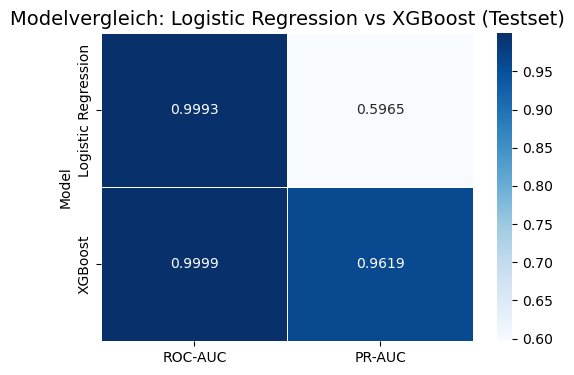

In [113]:
# Ergebnisse in einem DataFrame für die Heatmap
metrics_data = {
    "Model": ["Logistic Regression", "XGBoost"],
    "ROC-AUC": [logreg_roc_auc, xgb_roc_auc],
    "PR-AUC": [logreg_pr_auc, xgb_pr_auc]
}

# Konvertierung der Ergebnisse in ein DataFrame
metrics_df = pd.DataFrame(metrics_data).set_index("Model")

# Erstellung der Heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(metrics_df, annot=True, fmt=".4f", cmap="Blues", cbar=True, linewidths=0.5)
plt.title("Modelvergleich: Logistic Regression vs XGBoost (Testset)", fontsize=14)
plt.show()


## **Lernkurve – Logistic Regression mit SMOTE**

Zur Analyse der Modellzuverlässigkeit der Logistic Regression wurde eine Lernkurve auf Basis der **ROC-AUC** erstellt. Diese stellt die Modellleistung auf den Trainingsdaten sowie auf den Validierungsdaten (Stratified Cross-Validation) in Abhängigkeit von der Anzahl der Trainingsbeispiele dar.
### Beobachtungen

- Der **Training Score** liegt nahezu konstant bei einem sehr hohen Wert (≈ 1.00).
- Der Cross-Validation Score zeigt jedoch eine gewisse Schwankung, die mit zunehmender Anzahl der Trainingsbeispiele (von 20.000 bis 30.000) zunächst abnimmt, aber dann wieder leicht ansteigt und sich stabilisiert.
### Interpretation

- Es liegt **kein ausgeprägtes Overfitting** vor, da die Validierungsleistung auf einem hohen Niveau bleibt.
- Der leichte Abstand zwischen Training und Cross-Validation ist typisch für den Einsatz von **SMOTE**, da synthetische Minderheitsbeispiele erzeugt werden.
- Als lineares Modell ist die Logistic Regression in ihrer Modellierungskapazität begrenzt, insbesondere bei komplexen nicht-linearen Zusammenhängen.


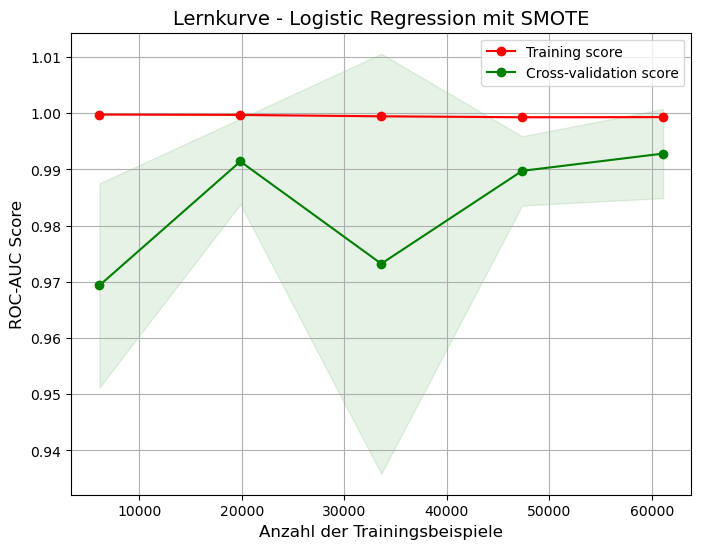

In [114]:
# Lernkurve für Logistic Regression mit SMOTE
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    logreg_pipeline, X_train, y_train, cv=cv, scoring="roc_auc", n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 5), random_state=42
)

# Durchnitt und Standardabweichung der Scores berechnen
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Lernkurve plotten
plt.figure(figsize=(8, 6))
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, "o-", color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score")
plt.title("Lernkurve - Logistic Regression mit SMOTE", fontsize=14)
plt.xlabel("Anzahl der Trainingsbeispiele", fontsize=12)
plt.ylabel("ROC-AUC Score", fontsize=12)
plt.legend(loc="best")
plt.grid()
plt.show()


## **Lernkurve – XGBoost mit SMOTE**

Zur Bewertung der Leistungsfähigkeit und Generalisierungsfähigkeit des XGBoost-Modells wurde ebenfalls eine Lernkurve auf Basis der **ROC-AUC** erstellt.
### Beobachtungen

- Der **Training Score** liegt durchgehend auf einem sehr hohen Niveau (≈ 1.00).
- Der **Cross-Validation Score** nähert sich schnell dem Trainingsniveau an und bleibt über alle Trainingsgrößen hinweg stabil.
- Die Varianz zwischen den einzelnen Cross-Validation-Folds ist gering, insbesondere bei größeren Trainingsmengen.
### Interpretation

- Das Modell zeigt eine **sehr gute Generalisierungsfähigkeit**.
- Der geringe Abstand zwischen Training und Validierung deutet auf ein **ausgewogenes Bias-Variance-Verhältnis** hin.
- XGBoost ist in der Lage, sowohl nicht-lineare Zusammenhänge als auch die durch SMOTE erzeugten synthetischen Daten effektiv zu verarbeiten, ohne stark zu überanpassen.


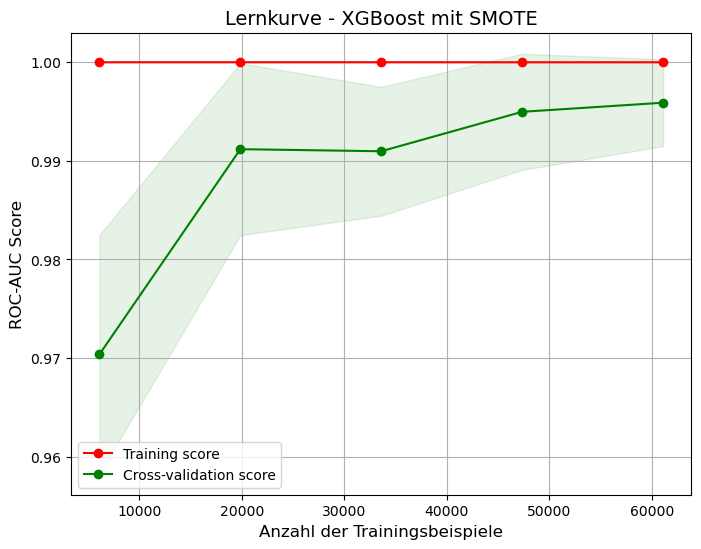

In [115]:
# Lernkurve für XGBoost mit SMOTE
train_sizes, train_scores, test_scores = learning_curve(
    xgb_pipeline, X_train, y_train, cv=cv, scoring="roc_auc", n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 5), random_state=42
)
# Durchnitt und Standardabweichung der Scores berechnen
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Lernkurve plotten
plt.figure(figsize=(8, 6))
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, "o-", color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score")
plt.title("Lernkurve - XGBoost mit SMOTE", fontsize=14)
plt.xlabel("Anzahl der Trainingsbeispiele", fontsize=12)
plt.ylabel("ROC-AUC Score", fontsize=12)
plt.legend(loc="best")
plt.grid()
plt.show()